# EXO 0748-676

In this notebook we will analyze subthreshold data that was saved by BAT around the time of a known flare from the Low Mass X-ray Binary EXO 0748-676. The astronomers telegram post related to the different detections of this source which triggered BAT and those that have subthreshold TTE data associated with them can be found [here](https://www.astronomerstelegram.org/?read=16790). 

Lets start off by importing the different python packages that we will need. 

In [1]:
import xspec
import batanalysis as ba
from swifttools.swift_too import GUANO, ObsQuery, Clock, Data
import swiftbat

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import scipy as sp
from pathlib import Path
from astropy.io import fits
from astropy.time import Time, TimeDelta
import astropy.units as u
from astropy.coordinates import SkyCoord
import ligo.skymap.plot
import datetime
import os



/Users/tparsota/miniforge3/lib/python3.12/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal



As is usual for our example notebooks, we will save the data in the /tmp/ directory. 

In [2]:
tmp_download_dir="/tmp/batdata/download_examples"

ba.datadir(tmp_download_dir, mkdir=True)

PosixPath('/private/tmp/batdata/download_examples')

Now, we can query the data. We can do this either using one of the trigger numbers provided in the astronomers telegram. Querying with the swiftools package finds this data. If we wanted to download this, then we can simply set `fetch=True`. Downloading data this way misses the necessary housekeeping data necessary to do in depth scientific analyses. The `download_swift_trigger_data` function takes this into account by also searching for the nearest observation with calibration data. 

A more relevant search could be one where a user knows that a flare of some source has occured and they wish to search for subthreshold data around this time. We can use a flare time from the telegram and pass that into `download_swift_trigger_data` to search for the subthreshold TTE data around that time. Once again, by default the function will also download the nearest observation with calibration/attitude data that occured closest in time to the time/trigger of interest. Additionally, the code will search for triggers around the time of interest. This timewindow can be specified with the `timewindow` parameter, which we set to be 400 seconds here.

In [3]:
trignum=1237121
Data(obsid=f"{trignum:08d}000", fetch=False, subthresh=True)

01237121000,sw01237121000msbal.fits.gz,BAT subthreshold trigger BAT file
'',sw01237121000msbat.hk.gz,BAT subthreshold trigger BAT housekeeping
'',sw01237121000msbevshsp_uf.evt.gz,BAT subthreshold trigger BAT slew/point unfiltered event file
'',sw01237121000msbevtlsp.hk.gz,BAT subthreshold trigger BAT housekeeping
'',sw01237121000msbevtssp.hk.gz,BAT subthreshold trigger BAT housekeeping
'',sw01237121000msbhd.hk.gz,BAT subthreshold trigger BAT housekeeping
'',sw01237121000msbno.fits.gz,BAT subthreshold trigger BAT file
'',sw01237121000mspob.cat.gz,BAT subthreshold trigger catalog


In [4]:
t=Time("2024-07-29T12:05:16")
result = ba.download_swift_trigger_data(triggertime=t.datetime, timewindow=400)
print(result)

/Users/tparsota/miniforge3/lib/python3.12/site-packages/swifttools/swift_too/swift_data.py:394: UserWarning: sw03104687002bdecb.hk.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/miniforge3/lib/python3.12/site-packages/swifttools/swift_too/swift_data.py:394: UserWarning: sw03104687002bdp.hk.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/miniforge3/lib/python3.12/site-packages/swifttools/swift_too/swift_data.py:394: UserWarning: sw03104687002ben.hk.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/miniforge3/lib/python3.12/site-packages/swifttools/swift_too/swift_data.py:394: UserWarning: sw03104687002bgocb.hk.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/miniforge3/lib/python3.12/site-packages/swifttools/swift_too/swift_data.py:394: UserWarning: sw03104687002bhd.hk.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/

/Users/tparsota/miniforge3/lib/python3.12/site-packages/swifttools/swift_too/swift_data.py:394: UserWarning: SWIFT_TLE_ARCHIVE.txt.24219.58610885.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/miniforge3/lib/python3.12/site-packages/swifttools/swift_too/swift_data.py:394: UserWarning: sw03104687002pat.fits.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/miniforge3/lib/python3.12/site-packages/swifttools/swift_too/swift_data.py:394: UserWarning: sw03104687002pjb.par.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/miniforge3/lib/python3.12/site-packages/swifttools/swift_too/swift_data.py:394: UserWarning: sw03104687002pob.cat.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/miniforge3/lib/python3.12/site-packages/swifttools/swift_too/swift_data.py:394: UserWarning: sw03104687002ppr.par.gz exists and not overwritten (set clobber=True to override this)

{np.int32(1245445): [Swift_Data(username='anonymous',obsid='01245445000',quicklook='False',auxil='True',subthresh='True',itsdc='False'), Swift_Data(username='anonymous',obsid='03104687002',quicklook='False',auxil='False',bat='True'), Swift_Data(username='anonymous',obsid='03104687002',quicklook='False',auxil='True',bat='False')], np.int32(1245446): [Swift_Data(username='anonymous',obsid='01245446000',quicklook='False',auxil='True',subthresh='True',itsdc='False'), Swift_Data(username='anonymous',obsid='03104687002',quicklook='False',auxil='False',bat='True'), Swift_Data(username='anonymous',obsid='03104687002',quicklook='False',auxil='True',bat='False')]}


We can see that there are two different subthreshold triggers that are found. These are downloaded into the `tdrss` subdirectory of the `/tmp/batdata/download_examples/` directory that we set earlier. Furthermore, looking in the directory for the trigger number 1245446 (which we know is the one associated with the LMXB source a priori), we see that the `download_swift_trigger_data` function has taken care of setting up the directory for us to load this subthreshold trigger into the `BatEvent` object, allowing us to proceed with our data analysis. 

In [5]:
!ls /tmp/batdata/download_examples/tdrss/2024_07/01245446000/

03104687002                      sw01245446000msbevtlsp.hk.gz
auxil                            sw01245446000msbevtssp.hk.gz
bat                              sw01245446000msbhd.hk.gz
sw01245446000msbal.fits.gz       sw01245446000msbno.fits.gz
sw01245446000msbat.hk.gz         sw01245446000mspob.cat.gz
sw01245446000msbevshsp_uf.evt.gz tdrss


Now, lets load this into the `BatEvent` object. Note that since this is subthreshold TTE data that is saved in a subdirectory of our `datadir()` path, we need to specify that with the `obs_dir` parameter that we pass. 

In [6]:
event=ba.BatEvent(result[1245446][0].obsid, obs_dir=result[1245446][0].entries[0].outdir)

Now, we know that the TTE data is energy calibrated and the associated attitude data is loaded in.

Let us then pretend that we dont know that our LMXB is actually detected in this TTE dataset and follow the steps to try to identify if the source is actually detected. (Even if it is not, we can still use this dataset to place upper limits in the BAT energy range). 

Lets create a skyview from the subthreshold TTE data where the skyview is constructed for 4 energy ranges (15-25, 25-50, 50-100, and 100-350 keV).

In [7]:
eresolved_skyview=event.create_skyview(energybins=[15,25,50,100,350]*u.keV)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 60520.503970 from DATE-OBS.
Set MJD-END to 60520.504086 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 60520.503970 from DATE-OBS.
Set MJD-END to 60520.504086 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 60520.503970 from DATE-OBS.
Set MJD-END to 60520.504086 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 60520.503970 from DATE-OBS.
Set MJD-END to 60520.504086 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 60520.503970 from DATE-OBS.
Set MJD-END to 60520.504086 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 60520.503970 from DATE-OBS.
Set MJD-END to 60520.504

Lets plot the SNR image in the 15-25 keV energy range in SKYX/Y coordinates and in a healpix projection with celestial coordinates. There seem to be a a pixel near the location of the LMXB that has a relatively high SNR. Next we will run the source detection on the skyview. 

/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:316: UserWarning: No astropy World Coordinate System has been specified the sky image is assumed to be in the detector tangent plane. No conversion to Healpix or RA/Dec & galactic coordinate systems will be possible.
/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:316: UserWarning: No astropy World Coordinate System has been specified the sky image is assumed to be in the detector tangent plane. No conversion to Healpix or RA/Dec & galactic coordinate systems will be possible.


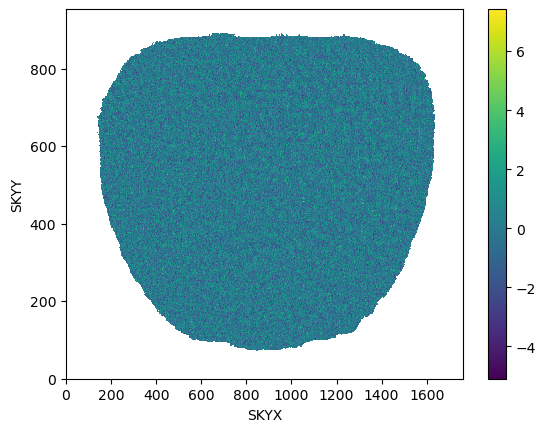

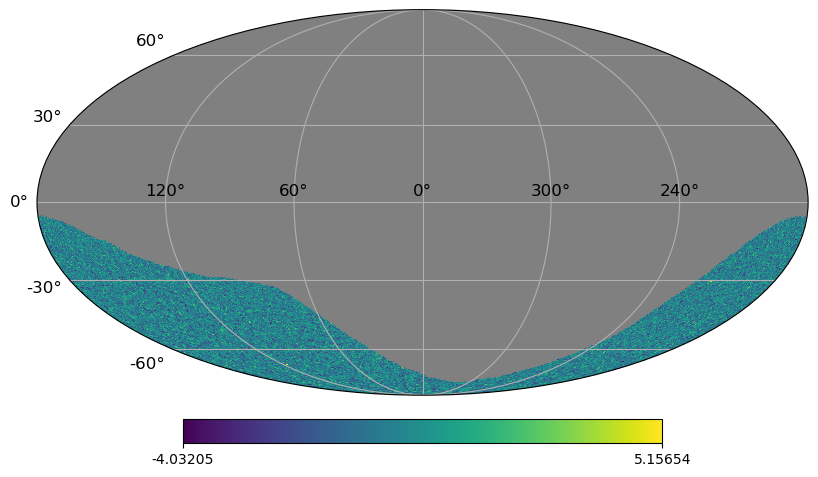

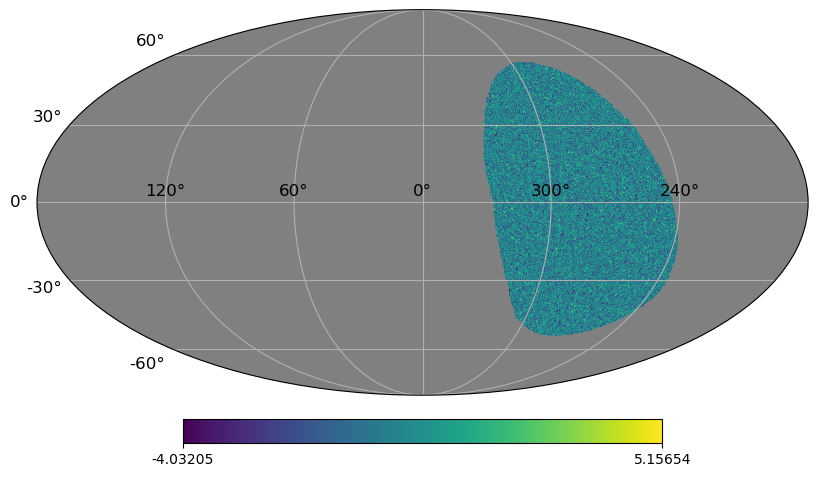

In [8]:
ra_dec_ax = eresolved_skyview.snr_img.plot(emin=15*u.keV, emax=25*u.keV) #, projection="healpix", coordsys="icrs")
plt.savefig(f'{event.result_dir.joinpath("norm_ra_dec_localization.pdf")}')

eresolved_skyview.snr_img.plot(emin=15*u.keV, emax=25*u.keV, projection="healpix", coordsys="icrs")
eresolved_skyview.snr_img.plot(emin=15*u.keV, emax=25*u.keV, projection="healpix", coordsys="galactic")

Detecting the sources in the image using our `detect_sources` method will show us that the LMXB EXO 0748-676 is detected very strongly with CENT_SNR=7.44 in the lowest energy bin. We have just confirmed that the source is detected and are confident in applying the mask weighting for the coordinates of the LMXB. If the source was not detected, we can still follow the mask weighting and spectral fitting steps to place upper limits on the emission from the source in the BAT energy range. 

In [9]:
eresolved_sources = eresolved_skyview.detect_sources()
c=eresolved_sources["SKYCOORD"][0]
eresolved_sources

CATNUM,NAME,SKYCOORD,ALWAYS_CLEAN,TIME,TIME_STOP,EXPOSURE,IMX,IMY,IMX_ERR,IMY_ERR,IMXPIX,IMYPIX,RA_OBJ_ERR,DEC_OBJ_ERR,ERR_RAD,IMX_FWHM,IMY_FWHM,IMX_FHWM_ERR,IMY_FHWM_ERR,THETA,PHI,GRMCLON,GRMCLAT,COUNTS,COUNTS_ERR,CENT_COUNTS,CONTAM_COUNTS,BKG,BKG_ERR,BKG_VAR,BKG_CELL,BKG_FIT,SNR,CENT_SNR,NPIXSOU,NPIXBKG,DETECT_METHOD,CHI2,DOF,CHI2_NU,DETECT_STATUS,CONSTRAINT_FLAG,SRC_WINDOW_RAD,BKG_WINDOW_RAD,NGOODPIX,BAT_ZOBJ,PCODEFR,RA_PER_IMX,DEC_PER_IMX,RA_PER_IMY,DEC_PER_IMY,GAINAPP,CLOCKAPP,BACKAPP,ACOLAPP,PCODEAPP,FFAPP,NGPIXAPP,BDISTAPP,MSKWTAPP
,,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int16,str30,SkyCoord,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[4],float64[4],float64[4],float64[4],float64[4],float64[4],float64[4],float64[4],float64[4],float64[4],float64[4],int32,int32,int32,float64[4],float64[4],float64[4],int32,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,int32,int32,int32,int32,int32,int32,int32,int32,int32
288,EXO 0748-676,"117.13879907014511,-67.74999973847808",True,743947548.0,743947558.0726,10.0726000070572,-0.3641805942608935,-0.03985463758566557,0.0,0.0,1053.003744668743,457.69106994506603,0.0,0.0,0.0,0.006529800274994075,0.006529800274994075,0.0,0.0,20.120554823747145,173.75460550891745,2.2822946461403633,-19.99602696343917,0.177143326820768 .. -0.018003729753115795,0.02388616003113749 .. 0.017321800133132594,0.15460082846782344 .. -0.022705866073259456,-0.004698484717823449 .. -0.00024335267674054496,-0.004698484717823449 .. -0.00024335267674054496,0.008115401950371243 .. 0.005860116179971059,0.020767496898770332 .. 0.015115311369299889,-0.004179819952696562 .. -0.004179819952696562,-0.004698484717823449 .. -0.00024335267674054496,8.529835236487111 .. -1.191092218562064,7.444365068232058 .. -1.502176535997561,0,0,2,134.7491972439051 .. 154.4663188943249,111.0 .. 111.0,1.2139567319270728 .. 1.3915884585074316,0,11,6,30,16211,0.0,0.9765625,133.5034505416388,-0.7058258120196115,0.04759759519856743,53.761314958933326,1,0,0,1,1,1,1,0,1
8049,ESO 323-32,"193.33500339863548,-41.63700182309321",False,743947548.0,743947558.0726,10.0726000070572,0.5075150217288837,-0.12613100200079821,0.0,0.0,638.029213779816,416.6592947985648,0.0,0.0,0.0,0.006529800274994075,0.006529800274994075,0.0,0.0,27.607482161801205,13.95676426318091,7.188812135084492,26.726421351656757,0.011664974674910056 .. 0.005822176854818666,0.0272134117439134 .. 0.0200368185997238,0.006147180752607225 .. -0.003714795862430433,0.0015432489348927748 .. 0.002738233362430433,0.0015432489348927748 .. 0.002738233362430433,0.009176063430733204 .. 0.006781602940330728,0.02372625470161438 .. 0.01751946471631527,0.0009247106499969959 .. 0.0009247106499969959,0.0015432489348927748 .. 0.002738233362430433,0.4916483794686883 .. 0.33232618399560315,0.25908769967764694 .. -0.2120382056519668,0,0,2,83.33316826114174 .. 86.97582019163119,111.0 .. 111.0,0.7507492636138895 .. 0.783565947672353,0,11,6,30,16211,0.0,0.78125,24.573703001351532,41.462459961394416,-60.077187953311295,23.01341152843861,1,0,0,1,1,1,1,0,1
8041,IGR J11098-6457,"167.44200082763615,-64.94599987303361",False,743947548.0,743947558.0726,10.0726000070572,-0.014477770459005081,-0.12878269360648809,0.0,0.0,886.5401022074356,415.37011990531477,0.0,0.0,0.0,0.006529800274994075,0.006529800274994075,0.0,0.0,7.3840317935585515,96.4142691208283,7.338314094249825,-0.8226642568272052,0.017195558311943568 .. 0.04425176308811905,0.022573259399204265 .. 0.01686866120107861,0.04198293206772729 .. 0.04782595825524759,-0.0026762914427272896 .. -0.006688262942747586,-0.0026762914427272896 .. -0.006688262942747586,0.007330067610674105 .. 0.005480521236666778,0.02022317424416542 .. 0.01507603656500578,0.00210426258854568 .. 0.00210426258854568,-0.0026762914427272896 .. -0.006688262942747586,0.8502897766855098 .. 2.9352385089616617,2.075981325228396 .. 3.1

Applying the mask weighting is as simple as taking the coordinates for the LMXB and passing them to the `apply_mask_weighting` method. 

In [10]:
event.apply_mask_weighting(ra=c.ra, dec=c.dec)

With the mask weighting complete, lets construct a lightcurve for this outburst. We will use 1 second time bins and will use our default energy bins. We only plot the single 15-350 keV energy range below. 

We can easily see that this subthreshold TTE dataset is only 10 seconds long which is expected. 

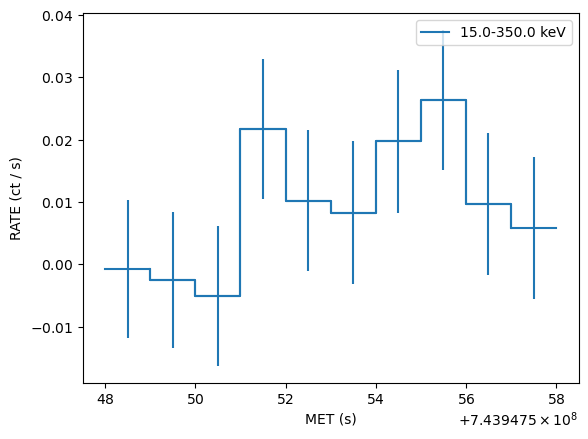

In [11]:
lc=event.create_lightcurve()
lc.set_timebins(timebinalg="uniform", timedelta=np.timedelta64(1, 's'))

fig, ax = lc.plot(energybins=[15,350]*u.keV)

Lets now plot this relative to the trigger time in teh different energy bands to see the energy resolved behavior of this outburst. We first save the triggertime to the `.trigtime` attribute of our `BatEvent` object. We can now easily plot the energy resolved lightcurve relative to the trigger time. We also plot the exposure fraction to verify that Swift was not slewing during this time period. 

We can see that the LMXB is primarily detected in the 15-25 keV energy band where there is a gradual rise in the counts recieved from the source. 

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: ylabel='RATE (ct / s)'>,
        <Axes: xlabel='MET - T0 (T0= 743947549.89531 s)', ylabel='Fractional Exposure'>],
       dtype=object))

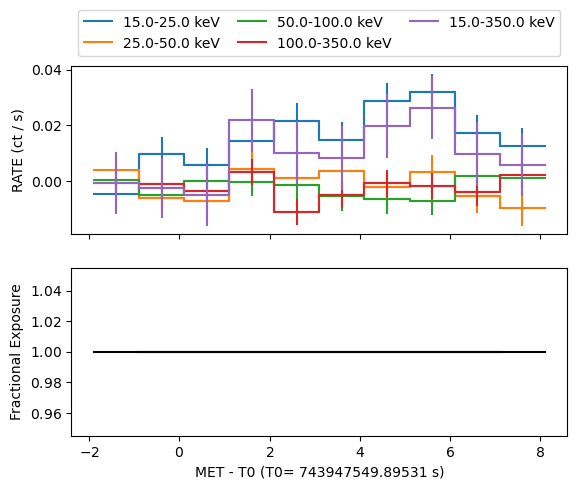

In [12]:
event.trigtime=Clock(utctime=t)

lc.plot(plot_relative=True, T0=event.trigtime.mettime, plot_exposure_fraction=True)


We can easily construct time resolved spectra for the same timebins that our lightcurve is binned with. 

In [13]:
spectra=event.create_pha(tstart=lc.tbins["TIME_START"], tstop=lc.tbins["TIME_STOP"])

We will now fit the spectra serially. We use gaussian statistics (by setting `use_cstat=False`) and fit the spectra with a `cflux*po` model. Looking at the plotted spectra, and the fits, we can see that there aren't any spectra that look very good and the fits are very poor as well. 


1 spectrum  in use
 
Spectral Data File: t_743947548.0-743947549.0_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.844e-04 +/- 1.404e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 1 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_743947548.0-743947549.0_80chan.rsp for Source 1


Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4    2   powerlaw   PhoIndex            1.00000      +/-  0.0          
   5    2   powerlaw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared                  

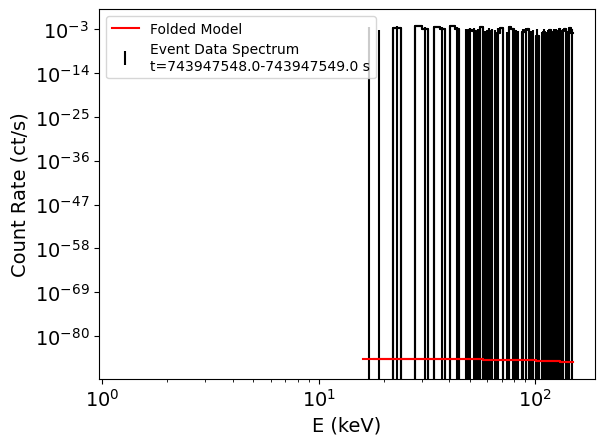

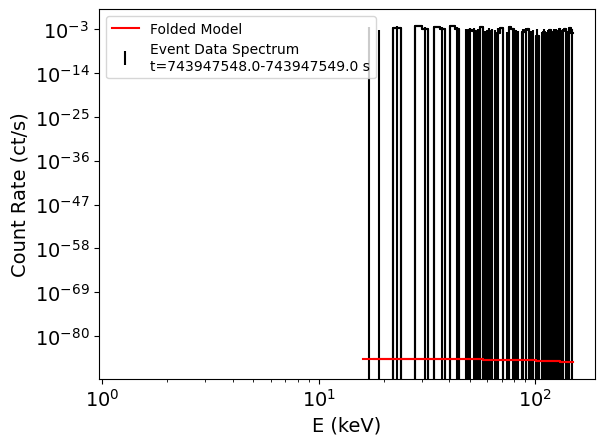

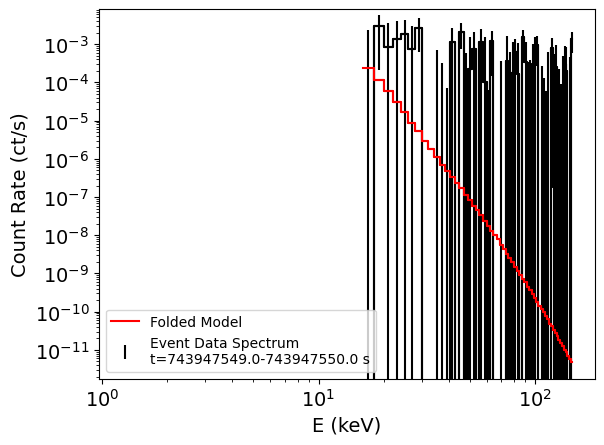

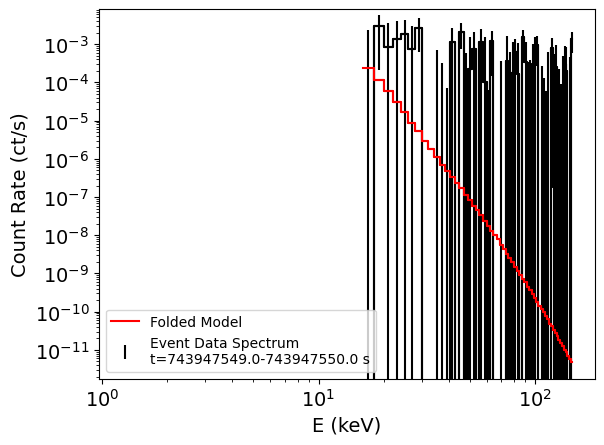

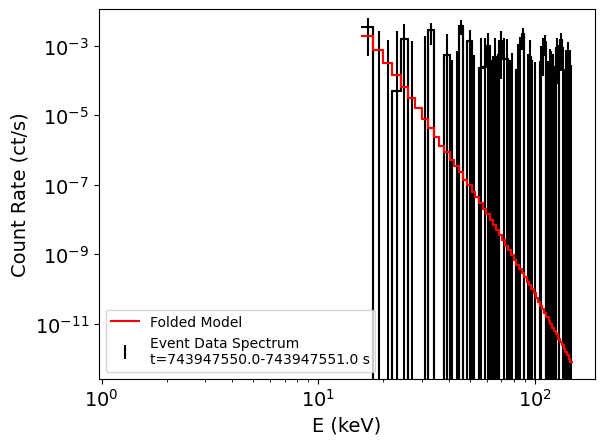

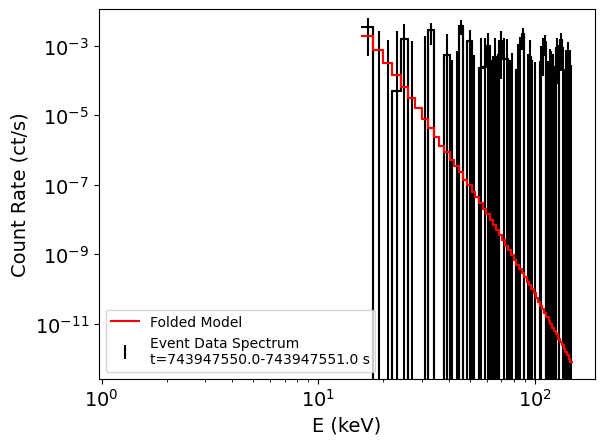

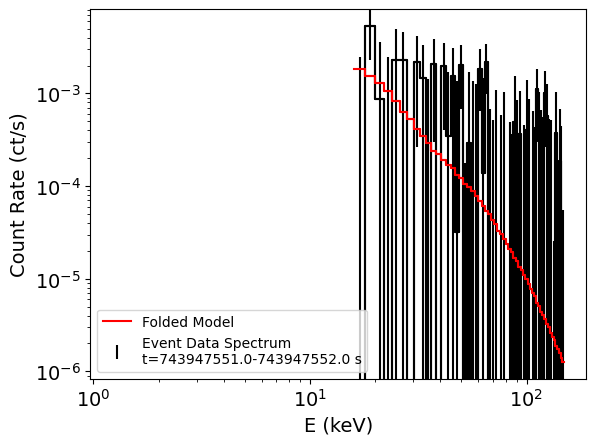

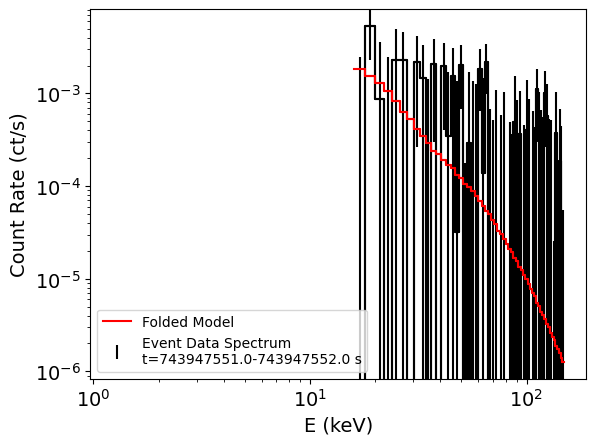

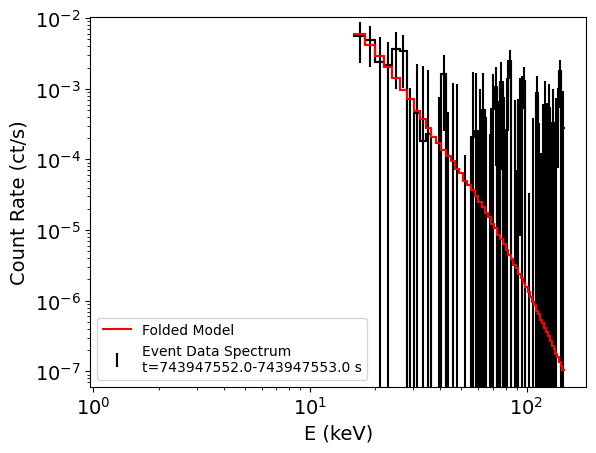

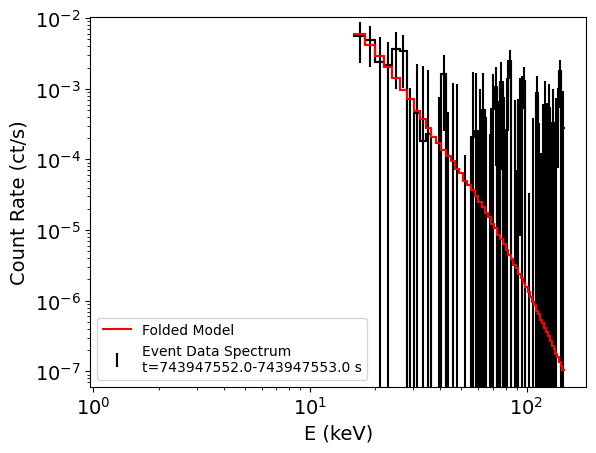

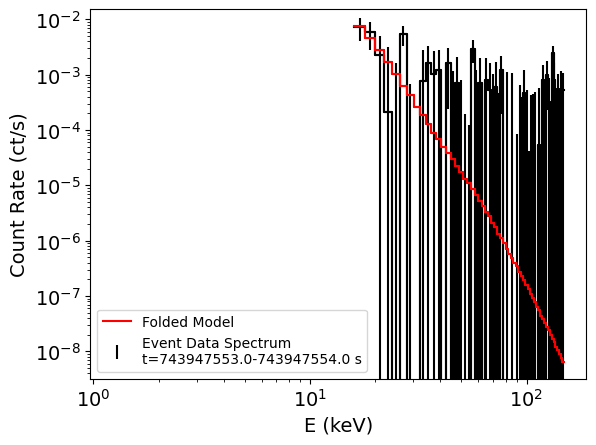

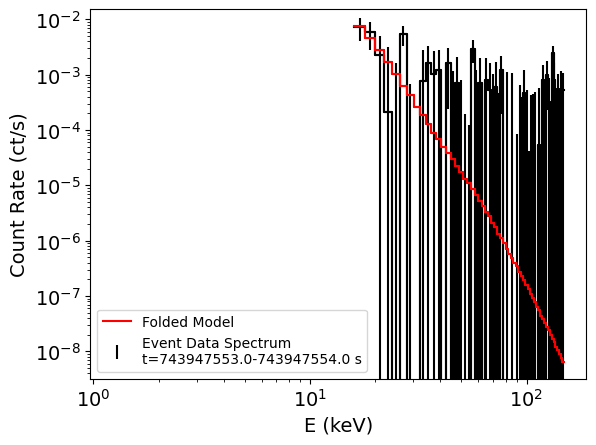

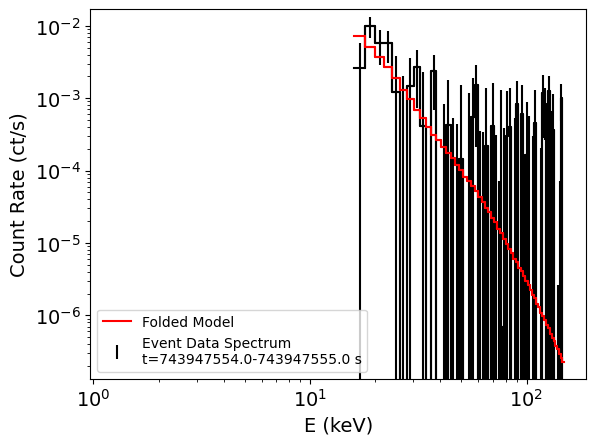

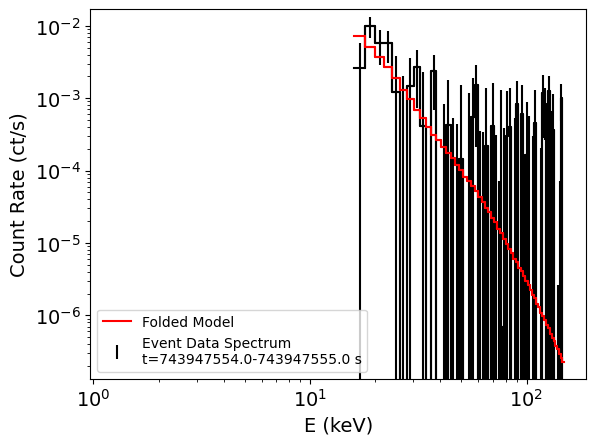

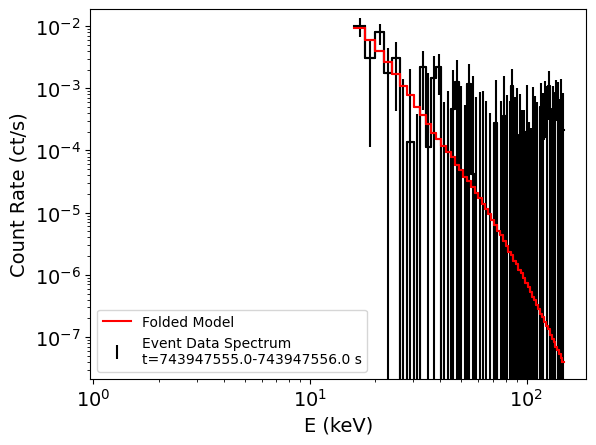

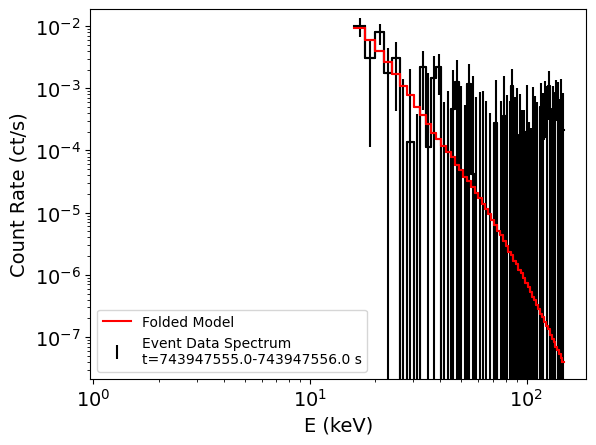

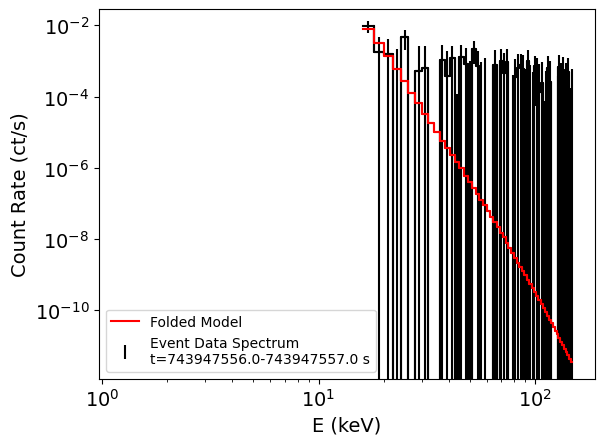

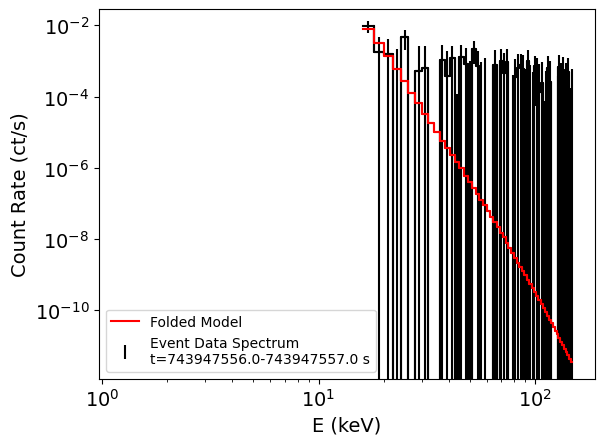

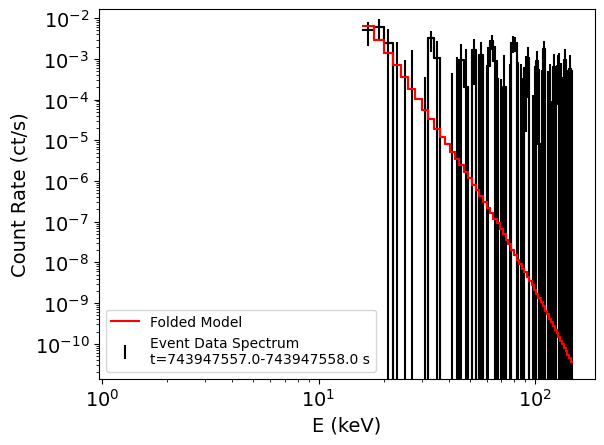

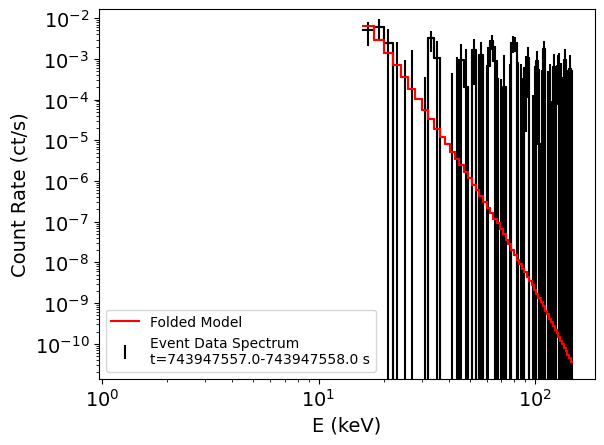

In [14]:
for i in spectra:
    ba.fit_spectrum(i, use_cstat=False, generic_model="cflux*po", setPars={1:"15,-1", 2:"150,-1",3:-8, 4:"2",5:"1e-3,-1"}, fit_iterations=10000)
    i.plot()

We can, at the very least, use the data to place flux upper limits on the LMXB source. Lets use the comprehensive `batspectrum_analysis` function which automatically calculates the upper limit if the spectrum is not well fit. Since we do not define `nprocs`, it gets set to 1 automatically which means that parallelization is disabled. 

In [15]:
upperlim_spectra=ba.parallel.batspectrum_analysis(spectra, use_cstat=False, generic_model="cflux*po", setPars={1:"15,-1", 2:"150,-1",3:-8, 4:"2",5:"1e-3,-1"}, fit_iterations=10000, ul_pl_index=1, recalc=True)


1 spectrum  in use
 
Spectral Data File: t_743947548.0-743947549.0_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.844e-04 +/- 1.404e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 1 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_743947548.0-743947549.0_80chan.rsp for Source 1


Fit statistic  : Chi-Squared                  264.98     using 80 bins.

Test statistic : Chi-Squared                  264.98     using 80 bins.
 Null hypothesis probability of 3.39e-22 with 78 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4    2   powerlaw

Lets plot the upper limits to see what they look like. We can see that the simple powerlaw fit to obtain the flux upper limit is not too bad.

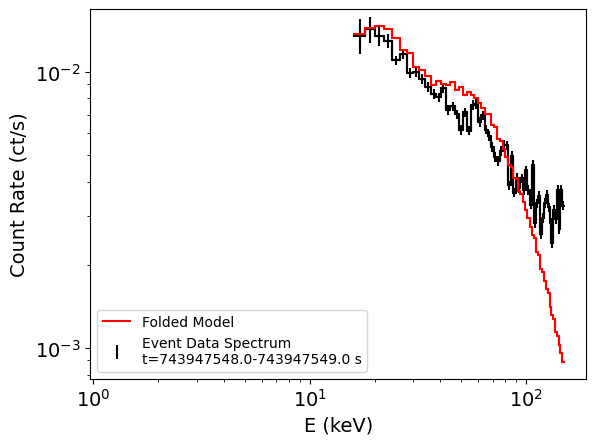

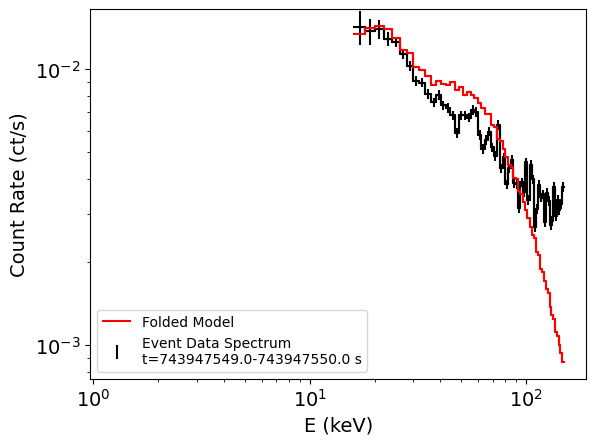

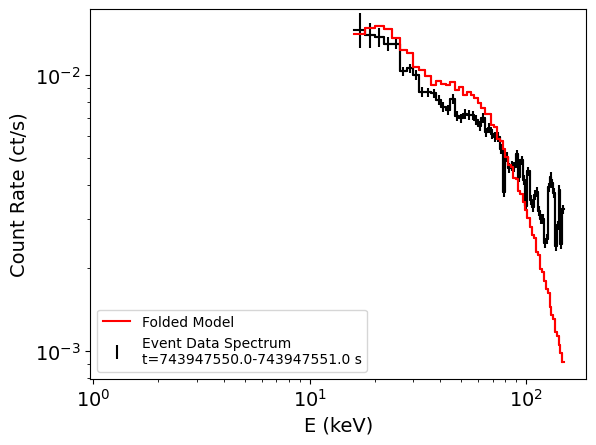

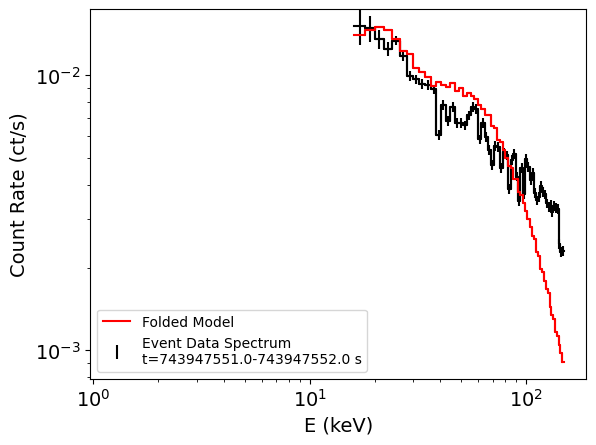

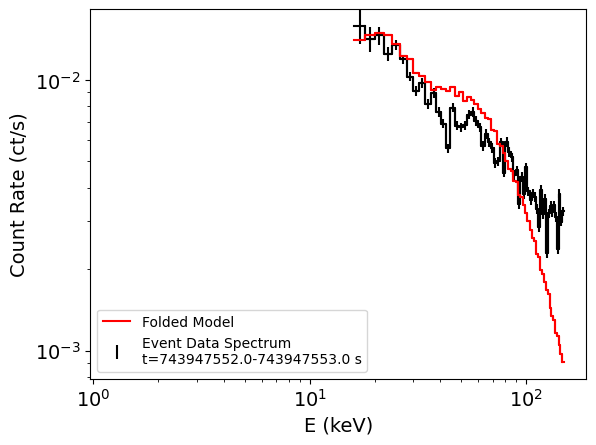

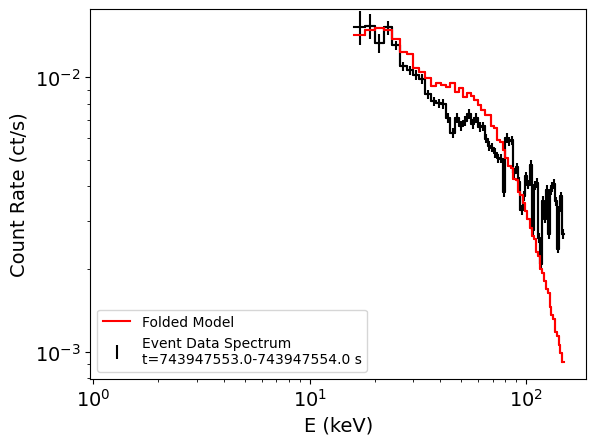

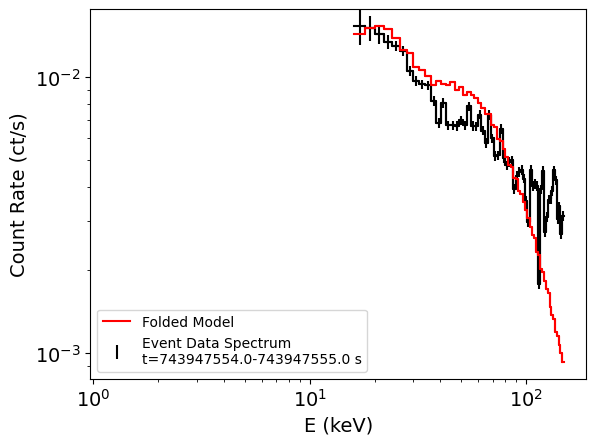

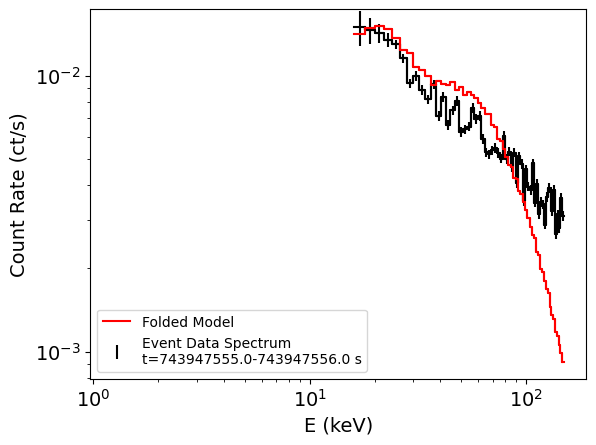

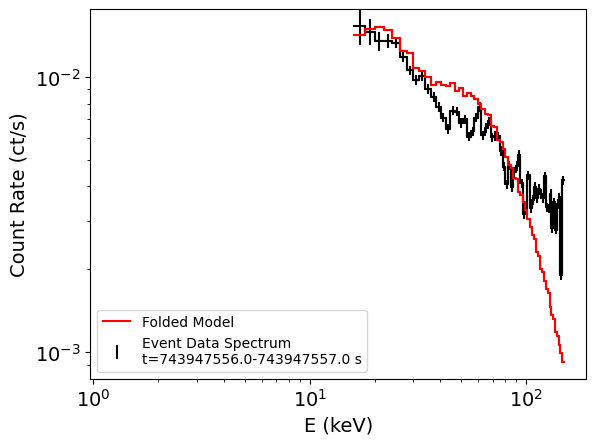

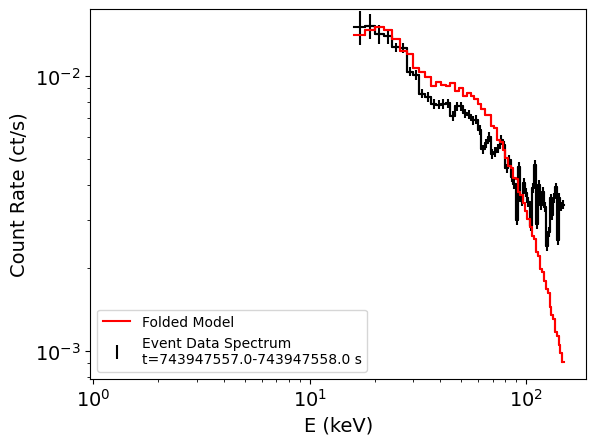

In [16]:
for i in upperlim_spectra:
    i.plot()

Finally, lets plot the lightcurve and the flux upper limits all together. This is easily done with the `plot_TTE_lightcurve` function. We cna modify the returned axes to make the plot look nicer. 

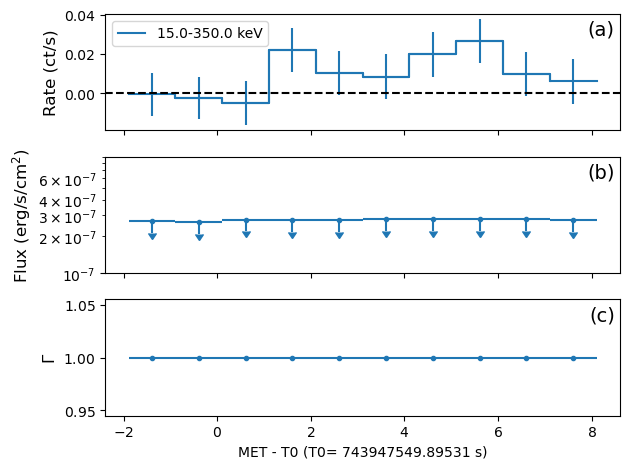

In [17]:
fig, ax = ba.plot_TTE_lightcurve(lc, upperlim_spectra, plot_relative=True, T0=event.trigtime.met)
ax[0].axhline(0, ls="--", color="k")
ax[1].set_ylim([1e-7, 9e-7])

ax[0].set_ylabel("Rate (ct/s)", fontsize=12)
ax[1].set_ylabel("Flux (erg/s/cm$^2$)", fontsize=12)
ax[2].set_ylabel(r"$\Gamma$", fontsize=12)


for a, l in zip(ax, ["a", "b", "c", "d"]):
    a.text(
        0.99, 0.95, f"({l})", ha="right", va="top", transform=a.transAxes, fontsize=14
    )

fig.tight_layout()
fig.savefig(f'{event.result_dir.joinpath("exo_lc.pdf")}', bbox_inches="tight")

We can also create a plot of the healpix map and the increased SNR signal around the EXO source. 

/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:316: UserWarning: No astropy World Coordinate System has been specified the sky image is assumed to be in the detector tangent plane. No conversion to Healpix or RA/Dec & galactic coordinate systems will be possible.
/var/folders/vs/mk2m3n7d5650zxfytqb8_ypw8nkvkq/T/ipykernel_55859/375383696.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


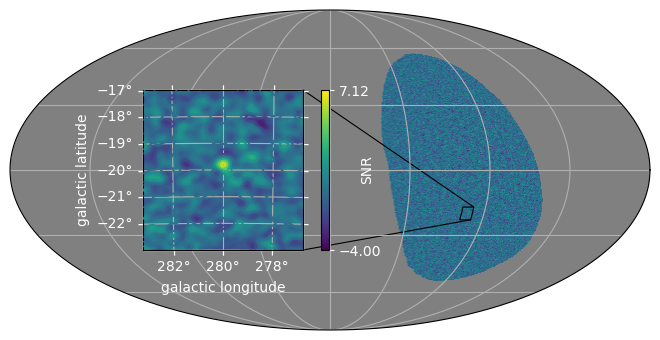

In [18]:
data=eresolved_skyview.snr_img.healpix_projection(coordsys="galactic", nside=512).slice[{'ENERGY':0}].project("HPX").contents

cmap = mpl.colormaps.get_cmap("viridis")
cmap.set_bad(color="gray")

fig = plt.figure(figsize=(9, 4), dpi=100)

ax_globe = plt.axes(
    [0.1, 0.1, 0.8, 0.8],
    projection='galactic degrees mollweide')

ax_inset = plt.axes(
    [0.15, 0.3, 0.4, 0.4],
    projection='galactic degrees zoom',
    center='280d -20d',
    radius=3*u.deg)

for i in ax_globe.coords:
    i.set_ticklabel_visible(False)
    i.set_ticks_visible(False)


ax_globe.mark_inset_axes(ax_inset)
ax_globe.connect_inset_axes(ax_inset, 'upper right')
ax_globe.connect_inset_axes(ax_inset, 'lower right')

ax_globe.imshow_hpx(data, cmap=cmap, vmin=np.floor(0.65*np.nanmin(data)), vmax=(np.nanmax(data)))


im = ax_inset.imshow_hpx(data, cmap=cmap, vmin=np.floor(0.65*np.nanmin(data)), vmax=(np.nanmax(data)))
ax_inset.contour_hpx(data, cmap=cmap, vmin=np.floor(0.65*np.nanmin(data)), vmax=(np.nanmax(data)))

ax_inset.grid()
ax_inset.set_xlabel("galactic longitude", color="w")
ax_inset.set_ylabel("galactic latitude", color="w")
for i in ax_inset.coords:
    i.tick_params(colors='w')

ax_globe.grid()

cbar=plt.colorbar(im)
cbar.set_ticks([np.floor(0.65*np.nanmin(data)), (np.nanmax(data))])
cbar.ax.tick_params(colors='w') 
cbar.set_label("SNR", color="w", labelpad=-15)

fig.tight_layout()
fig.savefig(f'{event.result_dir.joinpath("exo_image.pdf")}', bbox_inches="tight")